# Séance 4 - Réseau récurrent

Dans cette séance nous allons entraîner un modèle à copier le style de poésie de Beaudelaire, spécifiquement l'oeuvre *Les fleurs du mal*. Ce TP est largement inspiré du cours du [CNAM](https://cedric.cnam.fr/~thomen/cours/US330X/tpRNNs.html) que l'on a adapté ici.

Pour cela, nous utiliserons le projet [Gutenberg](https://www.gutenberg.org) qui permet l'accès l'ensemble des oeuvres littéraires classique gratuitement. C'est sur ce dataset, entre autres, que les LLM s'entraînent.

Commençons par importer les packages dont nous aurons besoin.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style="whitegrid")

from tensorflow import keras

Après avoir chargé dans l'environnement le fichier .txt de poésie, nous devons le travailler un peu pour l'exploiter. Quand on regarde le détail du fichier, on voit qu'il y a du texte qui n'est pas de la poésie. Nous décidons de n'exploiter que les poèmes.

In [ ]:
start = False
book = open("Beaudelaire.txt", encoding="utf8")  # noqa: SIM115
lines = book.readlines()
verses = []

for line in lines:
    line_stripped = line.strip().lower()
    if "AU LECTEUR".lower() in line_stripped and not start:
        start = True
    if (
        "End of the Project Gutenberg EBook of Les Fleurs du Mal, by Charles Baudelaire".lower()
        in line_stripped
    ):
        break
    if not start or len(line_stripped) == 0:
        continue
    verses.append(line_stripped)

book.close()
text = " ".join(verses)
characters = sorted(set(text))
n_characters = len(characters)

On décide ici de le découper en séquence de 32 caractères et de se décaler d'un caractère à chaque fois. Nous allons donc prédire le caractère suivant à partir des 32 caractères précédents.
Construisons deux listes qui, une fois transformée, deviendront $X$ et $y$.

**Consigne** : Compléter la cellule suivante avec les informations précédentes.

In [ ]:
sequence_length = 32
stride = 1
sequences = []
y_character = []
for index in range(0, len(text) - sequence_length, stride):
    sequences.append(text[index : index + sequence_length])
    y_character.append(text[index + sequence_length])

Un réseau de neurone ne comprend pas le texte, donc nous devrons jongler entre nombre et caractères. Pour cela, nous créons deux dictionnaires pour traduire ces deux visions.

In [ ]:
character_to_index = {character: index for index, character in enumerate(characters)}
index_to_character = dict(enumerate(characters))

Nous sommes maintenant prêt pour renseigner $X$ et $y$. La matrice $X$ sera de taille $n \times N \times C$ avec:
* $n$ : le nombre de séquence exemples
* $N$ : la longueur de la séquence que l'on considère, ici 32
* $C$ : le nombre de caractères différents, ici stocké dans la variable *n_characters*

La matrice $y$ sera de taille $n\times C$. Les deux matrices seront de types booléens avec la valeur *True* à l'index du caractères représenté.

**Consigne** : Remplir la cellule suivante avec les informations précédentes. On utilisera le dictionnaire *character_to_index*.

In [ ]:
X = np.zeros((len(sequences), sequence_length, n_characters), dtype=bool)
y = np.zeros((len(sequences), n_characters), dtype=bool)

for row, sequence in enumerate(sequences):
    for position, character in enumerate(sequence):
        X[row, position, character_to_index[character]] = 1
    y[row, character_to_index[y_character[row]]] = 1

Découpons à présent $X$ et $y$ en un jeu de test et un jeu d'entraînement. Aussi, nous allons sauvegarder ces matrices au cas où nous souhaiterions ne pas avoir à relancer ce preprocessing.

In [ ]:
import _pickle as pickle

train_size = 0.8
train_index = round(len(sequences) * train_size)
X_train = X[:train_index, :, :]
y_train = y[:train_index, :]

X_test = X[train_index:, :, :]
y_test = y[train_index:, :]


outfile = f"Baudelaire_len_{sequence_length}.p"

with open(outfile, "wb") as pickle_f:
    pickle.dump([index_to_character, X_train, y_train, X_test, y_test], pickle_f)

## Modélisation

Dans cet exemple, nous allons définir un réseau récurrent avec les neurones de bases : pas de LSTM ou GRU.

Un neurone [`SimpleRNN`](https://keras.io/api/layers/recurrent_layers/simple_rnn/) possède les mêmes attributs qu'un neurones classique en plus de deux paramètres majeurs:
* **return_sequences**: si l'on doit renvoyer la totalité de la séquence ou seulement la dernière valeur
* **unroll**: permet d'accélérer l'entraînement du réseau de neurone au prix de plus de mémoire impliquée

**Consigne** : Compléter la cellule suivante pour définir le réseau de neurones avec les informations précédentes.

In [ ]:
model = keras.models.Sequential(
    [
        keras.layers.InputLayer(shape=(sequence_length, n_characters)),
        # Ajouter une couche SimpleRNN
        keras.layers.SimpleRNN(128, return_sequences=True),
        # Ajouter une couche de LayerNormalization
        keras.layers.LayerNormalization(),
        # Ajouter une couche SimpleRNN
        keras.layers.SimpleRNN(128, return_sequences=False),
        # Ajouter une couche Dense
        keras.layers.Dense(n_characters, activation="softmax"),
    ],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 32, 128)        │        23,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 32, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 54)             │         6,966 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,542 (248.21 KB)

 Trainable params: 63,542 (248.21 KB)

 Non-trainable params: 0 (0.00 B)

Pour éviter l'overfitting, on se propose d'exploiter la mécanique d'[EarlyStopping](https://keras.io/api/callbacks/early_stopping/).

**Consigne** : Compléter la cellule suivante pour compiler le réseau de neurones et l'entraîner avec la mécanique d'EarlyStopping à paramétrer.

In [ ]:
n_epochs = 50
batch_size = 64
validation_split = 0.1

callback = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[callback],
)

Epoch 1/50
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.5332 - loss: 1.4744 - val_accuracy: 0.4982 - val_loss: 1.6537
Epoch 2/50
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.5345 - loss: 1.4680 - val_accuracy: 0.4965 - val_loss: 1.6555
Epoch 3/50
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.5357 - loss: 1.4609 - val_accuracy: 0.4932 - val_loss: 1.6608
Epoch 4/50
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.5365 - loss: 1.4585 - val_accuracy: 0.4951 - val_loss: 1.6449
Epoch 5/50
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.5386 - loss: 1.4508 - val_accuracy: 0.4953 - val_loss: 1.6524
Epoch 6/50
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.5399 - loss: 1.4484 - val_accuracy: 0.4934 - val_loss: 1.6657
Epoch 7/50
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.5397 - loss: 1.4452 - val_accuracy: 0.4943 - val_loss: 1.6644
Epoch 8/50
1529/1529 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.5412 -

L'entraînement étant terminé, visualisons sa courbe d'entraînement.

50 9


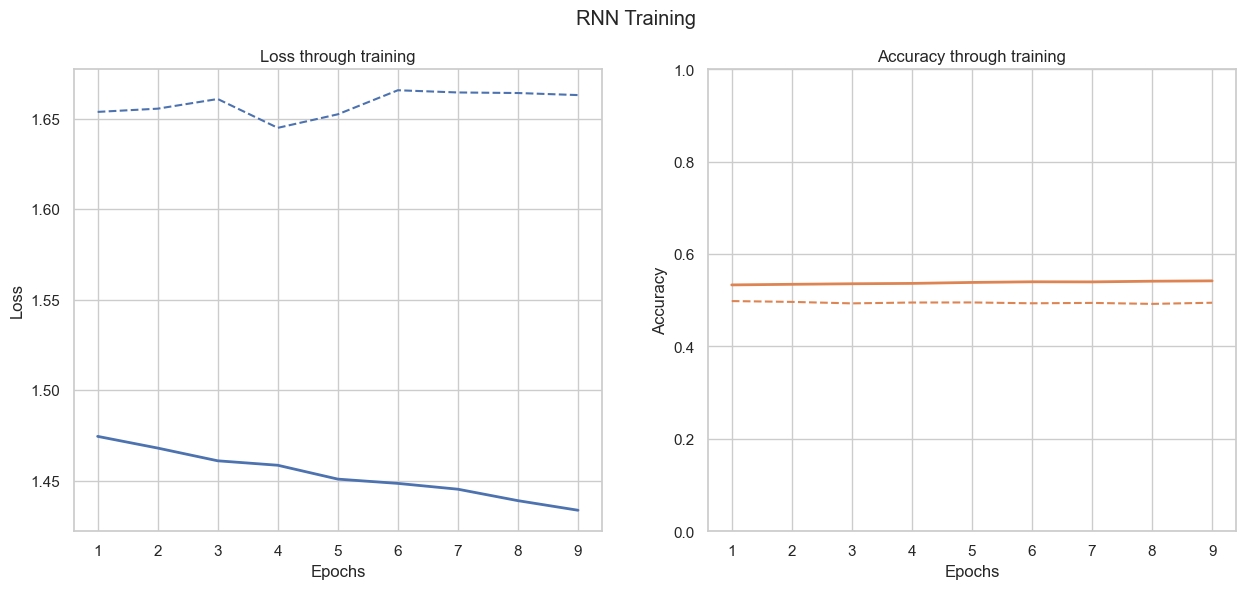

In [ ]:
historic = pd.DataFrame(history.history)
figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))
epochs = range(1, n_epochs + 1)

print(len(epochs), len(historic["loss"]))

for index, (metric_name, axis) in enumerate(
    zip(["loss", "accuracy"], [axis_1, axis_2], strict=False),
):
    color = sns.color_palette()[index]
    axis.plot(
        epochs[: len(historic[metric_name])],
        historic[metric_name],
        lw=2,
        color=color,
    )
    axis.plot(
        epochs[: len(historic["val_" + metric_name])],
        historic["val_" + metric_name],
        ls="--",
        color=color,
    )

    if metric_name == "accuracy":
        axis.set_ylim(0, 1)
    axis.set_ylabel(metric_name.capitalize())
    axis.set_xlabel("Epochs")
    axis.set_title(f"{metric_name.capitalize()} through training")


plt.suptitle("RNN Training")
plt.show()

Sauvegardons le modèle pour pouvoir l'utiliser plus tard, ou sur un autre notebook par exemple.

In [ ]:
def save_model(model, name) -> None:
    """Save a Keras model to JSON and H5 files."""
    model_json = model.to_json()
    with open(name + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(name + ".h5")


save_model(model, "SimpleRNN.weights")

Importons le modèle que l'on vient de sauvegarder sous un autre alias.

In [ ]:
from keras.models import model_from_json


def load_model(name):
    """Load a Keras model from JSON and H5 files."""
    with open(name + ".json") as json_file:
        model = model_from_json(json_file.read())
    model.load_weights(name + ".h5")
    return model


model_SimpleRNN = load_model("SimpleRNN.weights")

**Consignes** : Compléter la cellule suivante pour vérifier que les performances sont bien celles que nous connaissons.

In [ ]:
model_SimpleRNN.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)
score = model_SimpleRNN.evaluate(X_test, y_test)
print("Test accuracy: %.02f%%" % (score[1] * 100))

850/850 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4930 - loss: 1.6966
Test accuracy: 49.30%


## Génération de texte

On souhaite exploiter le modèle pour générer de la poésie dans le style de Beaudelaire.
On se propose de commencer par un bout d'un poème au hasard.

In [26]:
seed = 2025
sequence = ""
for index in range(sequence_length):
    character = index_to_character[np.argmax(X_train[seed, index, :])]
    sequence += character

print("Start sequence: " + sequence)

Start sequence: mère épouvantée et pleine de bla


Pour choisir le prochain caractère, nous pouvons simplement sélectionner le caractère le plus probable prédit par le modèle. Cette approche peut amener le modèle à dégénérer.

Nous allons essayer de sélectionner aléatoirement l'index du prochain caractère en s'appuyant sur le vecteur de probabilité produit par le réseau de neurone définit plus tôt.

**Consigne** : A l'aide de la fonction [np.random.multinomial](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multinomial.html), sélectionner un index aléatoirement selon un vecteur de probabilité à construire aléatoirement.

In [ ]:
random_index = np.random.multinomial(
    1,
    y_test[np.random.randint(0, len(X_test) - 1)].ravel(),
).argmax()

Nous allons en pratique exploiter le *temperature sampling* pour sélectionner le prochain caractère.

### Température

On considère un vecteur $u = (u_1, u_2, \ldots, u_d)$ et un paramètre $\tau > 0$ que l'on appelle la température. On peut construire le vecteur $v = (v_1, v_2, \ldots, v_d)$ à partir de $u$ et de $\tau$ comme:

$$\forall i \leqslant d, \quad v_i = \frac{\displaystyle \exp\left(\frac{u_i}{\tau}\right)}{\displaystyle \sum_{j=1}^d \exp\left(\frac{u_j}{\tau}\right)}$$

Cela ressemble à la fonction softmax mais paramétrer par la température $\tau$.

**Consigne** : Ecrire une fonction nommé `sampling` qui prend en paramètre un vecteur de probabilité et la température. Cette fonction doit renvoyer un index sélectionné selon le vecteur de probabilité définit par la température. On s'appuiera sur le travail de la cellule précédente.

In [29]:
def sampling(probabilities: np.ndarray, temperature: float = 1.0) -> int:
    """Sample an index from a probability array reweighted by temperature.

    Args:
        probabilities (np.ndarray): Array of probabilities.
        temperature (float, optional): Temperature parameter. Defaults to 1.0.

    Returns:
        int: Sampled index.

    """
    probabilities = np.asarray(probabilities).astype("float64")
    log_probabilities = np.log(probabilities + 1e-10) / temperature
    exp_probabilities = np.exp(log_probabilities)
    probabilities = exp_probabilities / np.sum(exp_probabilities)
    return np.random.multinomial(1, probabilities, 1).argmax()

Maintenant que nous sommes capables de sélectionner le prochain caractère avec plus de justesse, il ne nous restes plus qu'à générer la suite de la phrase !

In [30]:
def generate_sequence(start: str, length: int, model, temperature: float = 1) -> str:
    """Generate a sequence of characters given a starting string.

    Args:
        start (str): The starting string to seed the generation.
        length (int): The length of the sequence to generate.
        model: The trained Keras model for character prediction.
        temperature (float): The temperature parameter for sampling.

    Returns:
        str: The generated sequence of characters.

    """
    sequence = np.zeros((1, sequence_length, n_characters), dtype=bool)
    for position, character in enumerate(start):
        sequence[0][position][character_to_index[character]] = True

    generated_sequence = start

    for _ in range(length):
        probabilities = model.predict(sequence, verbose=0)[0]
        next_index = sampling(probabilities, temperature=temperature)
        character = index_to_character[next_index]
        generated_sequence += character

        for index in range(sequence_length - 1):
            sequence[0, index, :] = sequence[0, index + 1, :]

        sequence[0, sequence_length - 1, :] = 0
        sequence[0, sequence_length - 1, next_index] = 1

    return generated_sequence

Avec l'ensemble du travail, on a :

In [31]:
generate_sequence(start=sequence, length=50, model=model_SimpleRNN, temperature=0.5)

'mère épouvantée et pleine de blasphères, où les profonds des flamois ses monstres '

**Consignes** : Définir et comparer d'autres architectures de réseau de neurones pour répondre à ce problème. On conseille d'observer les performances avec les courbes d'apprentissage mais aussi avec plusieurs génération de texte.

## Pour continuer

Choisir une ou plusieurs pistes de recherche parmi les suivantes. Il est possible de choisir une autre direction, mais elle doit être validé auparavant.

1. Nous avons défini une seule architecture. On peut en essayer d'autres et les comparer à la fois avec les courbes d'apprentissages mais également avec la génération de texte.
2. Il existe une couche [`Embedding`](https://keras.io/api/layers/core_layers/embedding/). On se propose de l'exploiter et de mesurer ses performances.
